# Iris Example

In [1]:
# You dont need this, this is for my convinience
import sys
import os
notebook_dir = '\\'.join(os.getcwd().split('\\')[:-1])
sys.path.append(notebook_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nervos.utils import Module, Parameters, plot_spike_train
from nervos.dataloader import IrisLoader

In [3]:
class Iris_SNN(Module):
    def __init__(self, parameters, identifier=None):
        super().__init__(parameters, identifier)
        self.dataloader: IrisLoader = IrisLoader(
            parameters, [5, 5, 4, 4], [0.03, 0.03, 0.03, 0.03]
        )
        td = parameters.training_images_amount + parameters.testing_images_amount
        self.dataloader.fluff_data((td - 150) // 3)
        self.X_train, self.Y_train = self.dataloader.dataloader(preprocess=True)
        self.X_test, self.Y_test = self.dataloader.dataloader(
            preprocess=True, train=False
        )
        self.get_spikeplots = True

    def predict(self, X, model_location):
        spike_probs = self.dataloader.encode_coordinates(X)
        spike_train = self.dataloader.generate_poisson_spikes(
            spike_probs, self.parameters.training_duration
        )
        synapses, neuron_label_map = self.load_model(model_location)
        return self.get_prediction(spike_train, synapses, neuron_label_map)

p = Parameters()
p.from_url("https://pastebin.com/raw/83KPhYdD")

In [4]:
s3 =  Iris_SNN(p,"iris")
s3.initialise_layers(np.array([18,24]))

In [5]:
y3 = s3.train()

Epoch 1/3
1000/1000 [========================================]
Testing...
Test set accuracy: 0.945
Time elapsed since training start: 15.662s
Epoch 2/3
1000/1000 [========================================]
Testing...
Test set accuracy: 0.86
Time elapsed since training start: 31.399s
Epoch 3/3
1000/1000 [========================================]
Testing...
Test set accuracy: 0.945
Time elapsed since training start: 47.172s
Training complete!


In [12]:
def accuracy(s3_tt):
    spike_trains,labels = IrisLoader(p,[5,5,4,4],[0.03,0.03,0.04,0.04]).dataloader(train=False,preprocess=True,seed=42,size=2000)
    t = 0
    c = 0
    preds = []
    print('Calculating Accuracy')
    for st,label in zip(spike_trains,labels):
        pred = s3_tt.get_prediction(st)
        preds.append(pred)
        if pred == label:
            c+=1
        t+=1
        print(f"\rTested {t} samples",end='')
    print()
    print(c/t)
    return labels,preds

y_true,y_pred = accuracy(s3)

Calculating Accuracy
Tested 1998 samples
0.9574574574574575


Output: 1


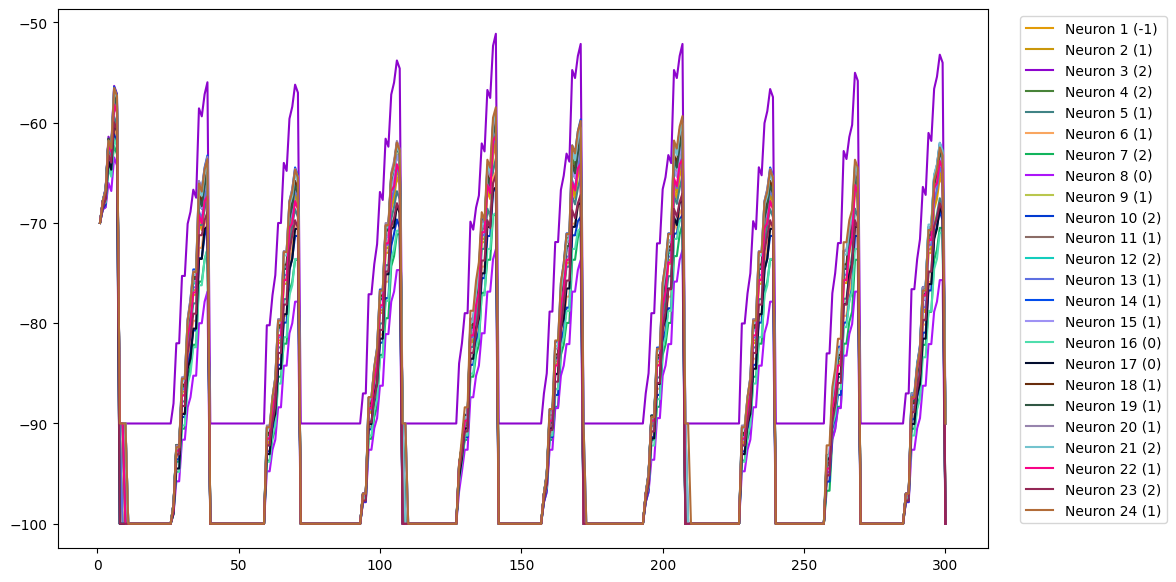

In [9]:
#epochs x trainign items x (num_layers - 1) x neurons_in_that_layer | accessig this will give us time,potential dict

colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for _ in range(24)]
def get_pp(train_idx):
    for j in range(24):
        duration = 300
        potentials:dict = s3.layerpotentials[0][train_idx][0][j]
        actual_potentials =[potentials.get(i,-100) for i in range(1,duration+1)]
        yield actual_potentials

plt.figure(figsize=(12,7))

train_idx = 934
print(f"Output: {s3.Y_train[train_idx]}")
for idx,pot in enumerate(get_pp(train_idx)):
    plt.plot(list(range(1,300+1)),pot,label=f"Neuron {idx+1} ({s3.learned_neuron_label_map[idx]})",color=colors[idx])

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()
    

0


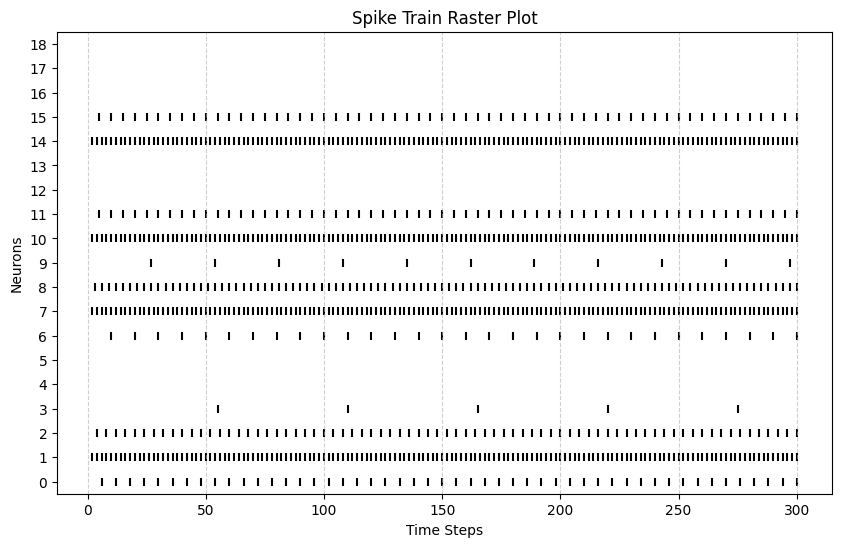

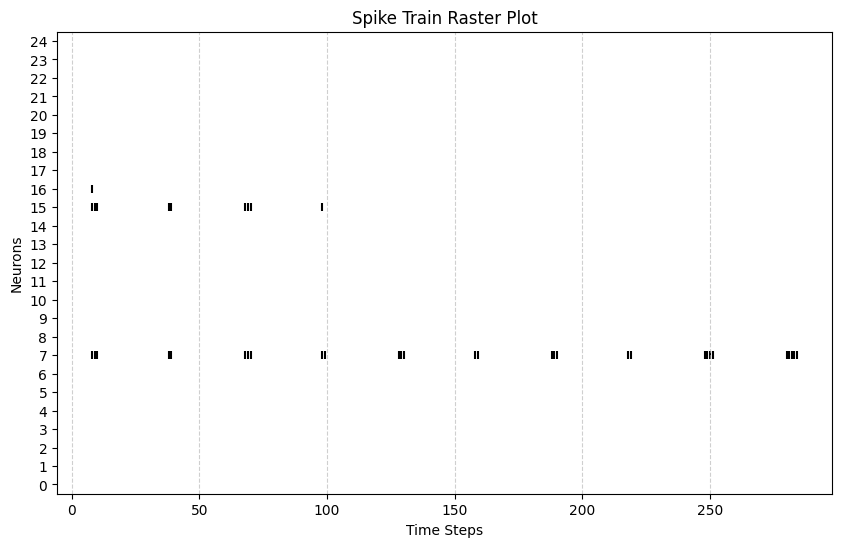

[-1  1  2  2  1  1  2  0  1  2  1  2  1  1  1  0  0  1  1  1  2  1  2  1]


In [10]:
# epochs x training images x layers x layer_size x train_duration
im = 283
ip_layer = s3.spikeplots[0][im][0].T
op_layer = s3.spikeplots[0][im][1].T
print(s3.Y_train[im])
# print(s2.learned_neuron_label_map[29])
plot_spike_train(ip_layer.T,(-0.5,18.5))
plot_spike_train(op_layer.T,(-0.5,24.5))
print(s3.learned_neuron_label_map)